In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange

from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.ewma import ewma_mean, ewma_cov, iterated_ewma
from cvx.covariance.covariance_combination import CovarianceCombination
sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
returns = pd.read_csv('../data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)

In [23]:
pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

# compute the covariance matrices, one time series for each pair
iewmas = {f"{pair[0]}-{pair[1]}": iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], lower=-4.2, upper=4.2, mean=True, min_periods_vola=63, min_periods_cov=63) for pair in pairs}

means = {f"{pair[0]}-{pair[1]}": iewmas[f"{pair[0]}-{pair[1]}"].mean for pair in pairs}
Sigmas = {f"{pair[0]}-{pair[1]}": iewmas[f"{pair[0]}-{pair[1]}"].covariance for pair in pairs}
Sigmas["10-21"] = regularize_covariance(Sigmas["10-21"], lamda=0.05)

In [24]:
combinator = CovarianceCombination(Sigmas=Sigmas, returns=returns, means=means)
results = list(combinator.solve_window(window=10, verbose=True))

100%|██████████| 3138/3138 [00:38<00:00, 81.74it/s] 


In [44]:
from collections import namedtuple

pred = namedtuple("pred", ["time", "mean", "covariance", "weights"])

cm_iewma_mean = {result.time: result.mean for result in results}
cm_iewma_cov = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}
times = [result.time for result in results]

cm_iewma = pred(times, cm_iewma_mean, cm_iewma_cov, weights)

In [45]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    prescient[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

# Experiments

In [30]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [31]:
names = ["CM-IEWMA", "PRESCIENT"]

predictors_temp = [cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

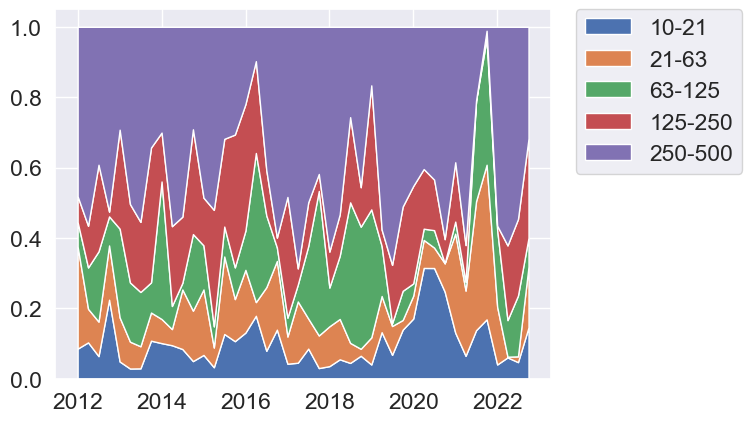

In [46]:
quarterly_weights  = pd.DataFrame(cm_iewma.weights).T.resample("Q").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=["10-21", "21-63", "63-125", "125-250", "250-500"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

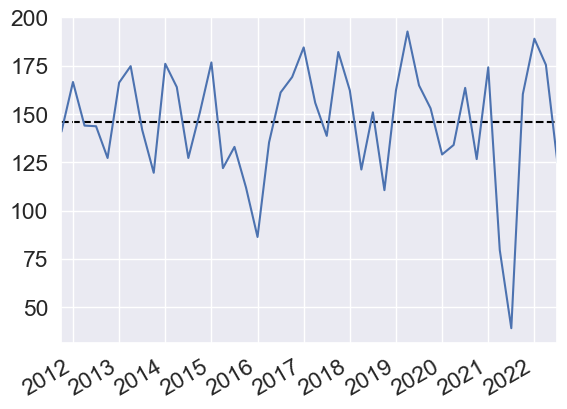

In [47]:
halflifes_vola = np.array([10, 21, 63, 125, 250])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Log likelihoods

In [48]:
names

['CM-IEWMA', 'PRESCIENT']

In [51]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    

    if names[i] == "CM-IEWMA'":
        times = pd.Series(predictor).index[1:]
        Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]
        log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)
    else:
        times = pd.Series(cm_iewma.covariance).index[1:]
        means_temp = np.stack([cm_iewma.mean[t] for t in predictor.keys()])[:-1]
        Sigmas_temp = np.stack([cm_iewma.covariance[t].values for t in predictor.keys()])[:-1]
        log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp, means=means_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing CM-IEWMA log-likelihood...


ValueError: Length of values (2770) does not match length of index (3137)

In [50]:
cm_iewma.mean

{Timestamp('2010-07-16 00:00:00'): array([-0.00261736, -0.00064656, -0.00269788,  0.00086393, -0.00065972,
         0.00055032,  0.00016585,  0.00019317, -0.00368616, -0.00034005,
        -0.0013896 , -0.00348122, -0.00716349,  0.00091425,  0.00131202,
         0.00015758,  0.00171265,  0.00128273, -0.00109924,  0.00053717,
        -0.00022439, -0.00240434, -0.00056944, -0.00124866,  0.00125048]),
 Timestamp('2010-07-19 00:00:00'): array([-1.60962666e-03, -7.26488016e-04, -4.43062097e-03,  6.85314971e-04,
        -3.46624559e-04,  9.68788642e-04,  1.40338988e-03,  9.23225632e-04,
        -2.78744042e-03,  4.13579495e-04, -6.56073801e-05, -3.86167759e-03,
        -9.20742839e-03,  7.21195978e-04,  2.70240745e-03,  1.35516531e-03,
         4.40746304e-03,  9.53723075e-04, -1.61476889e-03,  6.45607790e-04,
         5.73564704e-04,  1.85541356e-03, -5.66816324e-04,  8.56203568e-04,
         1.17709263e-03]),
 Timestamp('2010-07-20 00:00:00'): array([-0.00047493,  0.00224746, -0.00189345,  

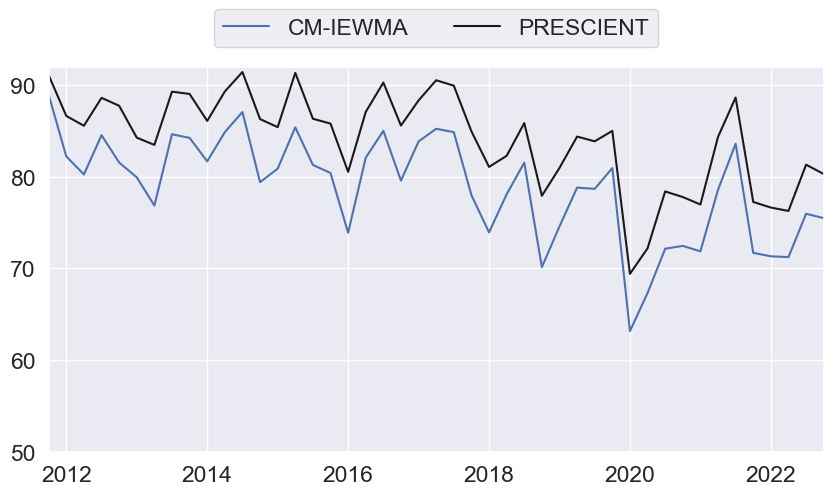

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

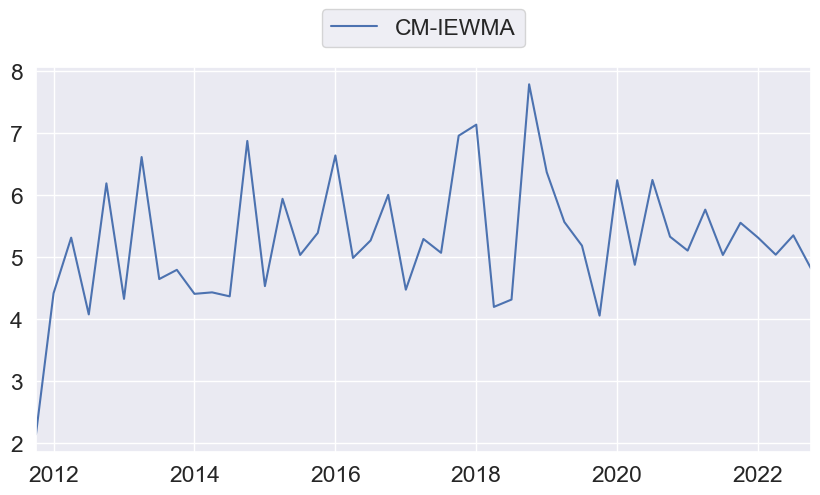

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Regret CDF plots

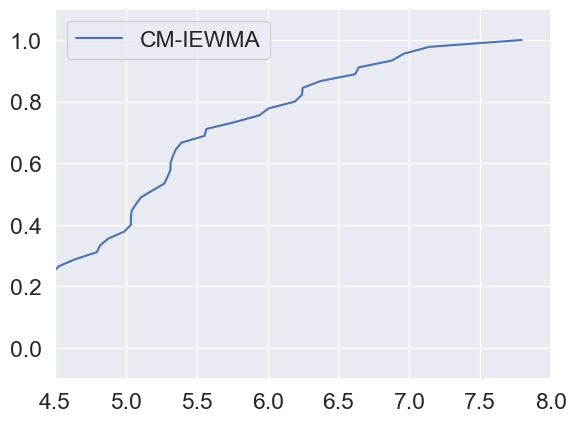

In [41]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();

### Regret metrics

In [42]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   CM-IEWMA & 5.3 & 1.0 & 7.8 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


In [43]:
cm_iewma

{Timestamp('2010-07-16 00:00:00'):           20678     21880         7     21446     21018     20436     20990  \
 20678  0.000170  0.000068  0.000114  0.000087  0.000074  0.000212  0.000123   
 21880  0.000068  0.000111  0.000063  0.000061  0.000047  0.000082  0.000078   
 7      0.000114  0.000063  0.000315  0.000082  0.000078  0.000190  0.000146   
 21446  0.000087  0.000061  0.000082  0.000104  0.000068  0.000108  0.000090   
 21018  0.000074  0.000047  0.000078  0.000068  0.000094  0.000098  0.000080   
 20436  0.000212  0.000082  0.000190  0.000108  0.000098  0.000523  0.000195   
 20990  0.000123  0.000078  0.000146  0.000090  0.000080  0.000195  0.000178   
 21645  0.000099  0.000065  0.000085  0.000069  0.000059  0.000143  0.000093   
 20792  0.000214  0.000098  0.000235  0.000135  0.000127  0.000359  0.000225   
 20440  0.000161  0.000082  0.000152  0.000089  0.000083  0.000249  0.000150   
 21394  0.000110  0.000057  0.000121  0.000057  0.000061  0.000190  0.000110   
 21305